# Two Sigma: Rental Interest Competition

In [1]:
from IPython.display import display
import datetime
import gc
import itertools
import json
import operator
import os
import pandas as pd
import pickle
import pprint
import numpy as np
import re
import seaborn as sns
import spacy
import torch
import torch.optim as optim

from collections import Counter, deque
from pytorch_pretrained_bert import BertAdam
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score,
    log_loss,
    make_scorer,
    mean_squared_error
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split
)
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from skorch.callbacks import (
    Callback,
    Checkpoint,
    EpochScoring,
    LRScheduler,
    ProgressBar,
    TrainEndCheckpoint
)

from utils.callbacks import SummarizeParameters
from utils.data import load_training_test_data
from utils.dataframe import (
    categories_from_column,
    column_list_to_category_flags,
    count_json_in_dataframes,
    count_ngrams_up_to_n,
    drop_columns_from_dataframes,
    map_categorical_column_to_category_ids,
    normalize_categories,
    normalize_description,
    numerical_feature_engineering_on_dataframe,
    parse_address_components,
    remove_outliers,
    remap_column,
    remap_columns_with_transform,
    remap_date_column_to_days_before,
    remove_small_or_stopwords_from_ranking
)
from utils.featurize import (
    featurize_for_tabular_models,
    featurize_for_tree_models,
)
from utils.gc import gc_and_clear_caches
from utils.doc2vec import (
    column_to_doc_vectors
)
from utils.model import (
    basic_logistic_regression_pipeline,
    basic_xgboost_pipeline,
    basic_adaboost_pipeline,
    basic_extratrees_pipeline,
    basic_svc_pipeline,
    basic_random_forest_pipeline,
    expand_onehot_encoding,
    format_statistics,
    get_prediction_probabilities_with_columns,
    get_prediction_probabilities_with_columns_from_predictions,
    prediction_accuracy,
    write_predictions_table_to_csv,
    rescale_features_and_split_into_continuous_and_categorical,
    split_into_continuous_and_categorical,
    test_model_with_k_fold_cross_validation,
    train_model_and_get_validation_and_test_set_predictions
)
from utils.language_models.bert import (
    BertClassifier,
    BertForSequenceClassification,
    TensorTuple,
    GRADIENT_ACCUMULATION_STEPS,
    WARMUP_PROPORTION,
    bert_featurize_data_frames,
    create_bert_model,
    create_bert_model_with_tabular_features,
)
from utils.language_models.descriptions import (
    descriptions_to_word_sequences,
    generate_bigrams,
    generate_description_sequences,
    maybe_cuda,
    postprocess_sequences,
    token_dictionary_seq_encoder,
    tokenize_sequences,
    torchtext_create_text_vocab,
    torchtext_process_texts,
    words_to_one_hot_lookups,
)
from utils.language_models.featurize import (
    featurize_sequences_from_dataframe,
    featurize_sequences_from_sentence_lists,
)
from utils.language_models.fasttext import (
    FastText,
    FastTextWithTabularData
)
from utils.language_models.simple_rnn import (
    CheckpointAndKeepBest,
    LRAnnealing,
    NoToTensorInLossClassifier,
    SimpleRNNPredictor,
    SimpleRNNTabularDataPredictor
)
from utils.language_models.split import (
    shuffled_train_test_split_by_indices,
    simple_train_test_split_without_shuffle_func,
    ordered_train_test_split_with_oversampling
)
from utils.language_models.textcnn import (
    TextCNN,
    TextCNNWithTabularData
)
from utils.language_models.ulmfit import (
    load_ulmfit_classifier_with_transfer_learning_from_data_frame,
    train_ulmfit_classifier_with_gradual_unfreezing
)
from utils.language_models.visualization import (
    preview_tokenization,
    preview_encoded_sentences
)
from utils.report import (
    generate_classification_report_from_preds,
    generate_classification_report
)

nlp = spacy.load("en")

Check GPU support

In [2]:
torch.cuda.is_available()

True

## 1 Exploratory Data Analysis

In [3]:
(ALL_TRAIN_DATAFRAME, TEST_DATAFRAME) = \
  load_training_test_data(os.path.join('data', 'train.json'),
                          os.path.join('data', 'test.json'))
TRAIN_INDEX, VALIDATION_INDEX = train_test_split(ALL_TRAIN_DATAFRAME.index, test_size=0.1)
TRAIN_DATAFRAME = ALL_TRAIN_DATAFRAME.iloc[TRAIN_INDEX].reset_index()
VALIDATION_DATAFRAME = ALL_TRAIN_DATAFRAME.iloc[VALIDATION_INDEX].reset_index()
TEST_DATAFRAME = TEST_DATAFRAME.reset_index(drop=True)

## 1.1 Initial Data Visualization

Take all the numerical features and show some statistics on all of them.

Immediately we can tell the following:
 - Price seems to have a pretty high range on the log scale, going from $40 \to 449000$. That's not particularly helpful since we think this is probably a pretty important feature, so lets filter out some of the super-high priced stuff.
 - Most properties are within the sweet spot of "-74 to -73" longitude and "40.70 to 40.80 latitude". There's a few others that aren't, so maybe better to filter those out.
 - Clearly there is some bogus data. Some properties have a lat/long of 0 which is incorrect. Unfortunately this also exists on the test set, but there are probably so few that we don't care.

In [4]:
ALL_TRAIN_DATAFRAME.head()

,id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
1,6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
2,9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium
3,10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
4,15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low


In [5]:
ALL_TRAIN_DATAFRAME.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


In [6]:
TEST_DATAFRAME.head()

,id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street
2,2,1.0,0,0,2016-06-17 01:23:39,Spacious studio in Prime Location. Cleanbuildi...,Sullivan Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7260,7174566,-74.0026,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/7174566_ba3a35c5...,2295,115 Sullivan Street
3,3,1.0,2,f9c826104b91d868e69bd25746448c0c,2016-06-21 05:06:02,For immediate access call Bryan.<br /><br />Bo...,Jones Street,"[Hardwood Floors, Dogs Allowed, Cats Allowed]",40.7321,7191391,-74.0028,41735645e0f8f13993c42894023f8e58,[https://photos.renthop.com/2/7191391_8c2f2d49...,2900,23 Jones Street
4,5,1.0,1,81062936e12ee5fa6cd2b965698e17d5,2016-06-16 07:24:27,Beautiful TRUE 1 bedroom in a luxury building ...,Exchange Place,"[Roof Deck, Doorman, Elevator, Fitness Center,...",40.7054,7171695,-74.0095,a742cf7dd3b2627d83417bc3a1b3ec96,[https://photos.renthop.com/2/7171695_089ffee2...,3254,20 Exchange Place


In [7]:
TEST_DATAFRAME.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,74659.000000,74659.000000,74659.000000,7.465900e+04,74659.000000,7.465900e+04
mean,1.212915,1.544663,40.735060,7.024001e+06,-73.945282,3.749033e+03
std,0.649820,1.107014,0.806687,1.264496e+05,1.487795,9.713092e+03
min,0.000000,0.000000,0.000000,6.811958e+06,-121.488000,1.000000e+00
25%,1.000000,1.000000,40.727800,6.915516e+06,-73.991800,2.495000e+03
50%,1.000000,1.000000,40.751600,7.021738e+06,-73.977700,3.150000e+03
75%,1.000000,2.000000,40.774300,7.129166e+06,-73.954700,4.100000e+03
max,112.000000,7.000000,42.872700,7.761779e+06,0.000000,1.675000e+06


In [8]:
CORE_NUMERICAL_COLUMNS = ['bathrooms', 'bedrooms', 'price', 'latitude', 'longitude']

In [9]:
NUMERICAL_QUANTILES = {
    'bathrooms': (0.0, 0.999),
    'bedrooms': (0.0, 0.999),
    'latitude': (0.01, 0.99),
    'longitude': (0.01, 0.99),
    'price': (0.01, 0.99)
}

We can then run a pairplot analysis on both the training and test dataframes and notice that while there isn't much correlation between price and amenities, there is quite a big correlation between things like price and location. Properties in pricier areas tend to have more amenities.

The cell for the correlation between latitude and longitude looks a little bit like the Greater New York area.

Price wise, most properties are sitting in the $2000-4000 range, steeply dropping off after that. Also, there are definitely "pricey" and "cheap" areas, with most of the cheaper properties sitting in the -73.85 to -73.95 longitude.

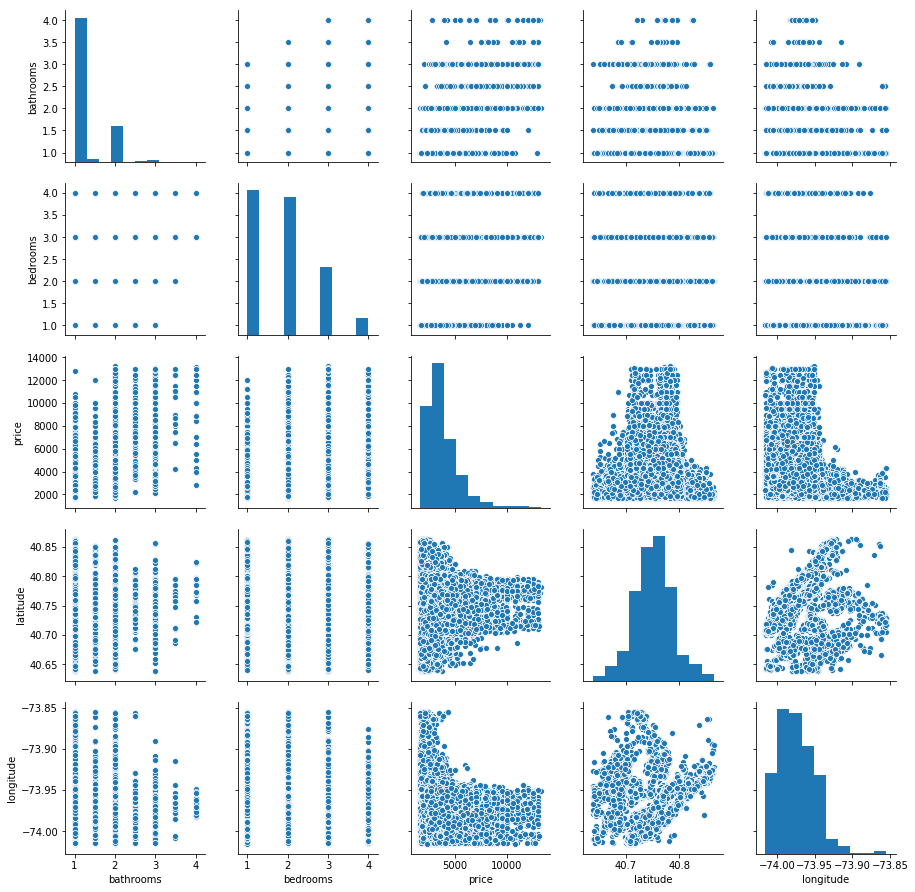

In [10]:
sns.pairplot(remove_outliers(ALL_TRAIN_DATAFRAME[CORE_NUMERICAL_COLUMNS],
                             NUMERICAL_QUANTILES))

The test set is distributed in a simialr way, though it has more properties to the north and south east.

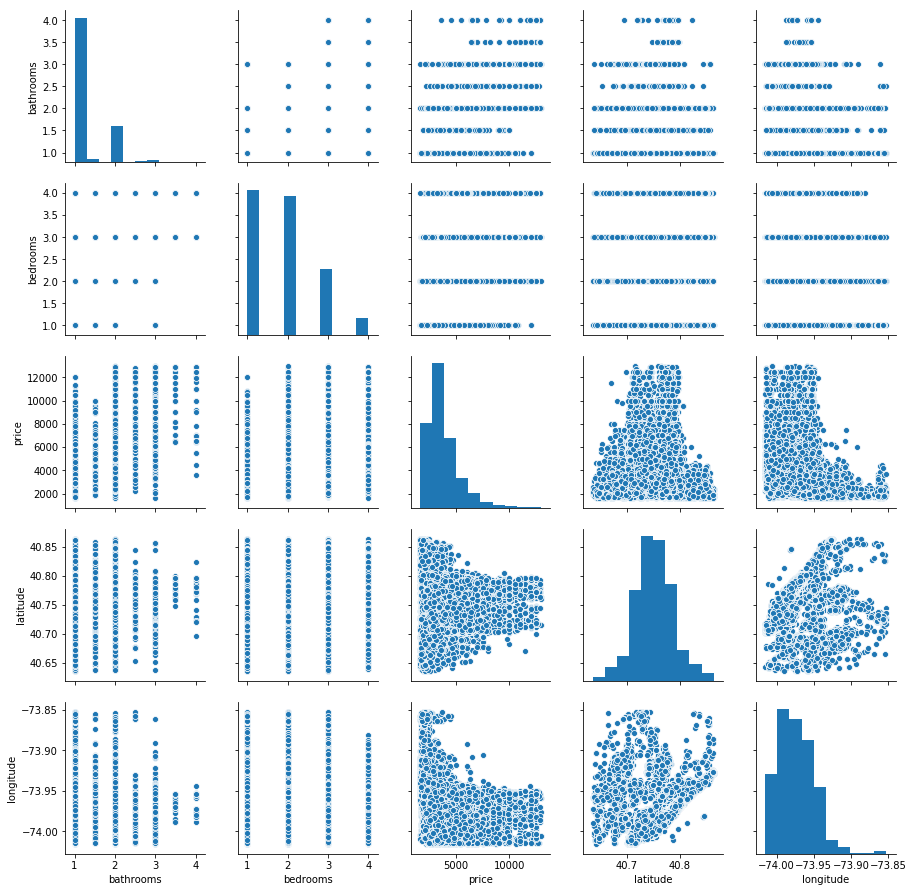

In [11]:
sns.pairplot(remove_outliers(TEST_DATAFRAME[CORE_NUMERICAL_COLUMNS],
                             NUMERICAL_QUANTILES))

## 1.2 Outlier Removal

Lets remove our outliers the training set.

In [12]:
TRAIN_DATAFRAME = remove_outliers(TRAIN_DATAFRAME, NUMERICAL_QUANTILES)

## 2 Data Cleaning and Feature Engineering

Let's see what this table looks like. We'll display the head of the table which shows its features

In [13]:
TRAIN_DATAFRAME.head()

,index,id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,17623,44382,1.5,3,c2d295bf6a178f7a5f0e00283f890a06,2016-05-15 02:12:37,Welcome to Prospect Heights! Prospect Heights ...,64 Underhill Ave,"[Dishwasher, Washer/Dryer Hookup, No pets]",40.6790,7015180,-73.9655,6d9b4949574486ce2cba1ec127ec3459,[https://photos.renthop.com/2/7015180_1a70d891...,3400,64 Underhill Ave,low
1,37064,93121,1.0,1,d64510d4269e11e83acb1b93a6c43723,2016-04-26 03:13:05,*PRIME LOCATION-MIDTOWN EAST**- GREAT Value fo...,E 55 Street,"[Hardwood Floors, Dogs Allowed, Cats Allowed]",40.7592,6925483,-73.9689,3e0c28a1f4b9c11b809ff21dbb920b5c,[https://photos.renthop.com/2/6925483_e57d2ff5...,2118,161 E 55 Street,high
2,8022,20285,1.0,3,89a7bc0f896e2d06828d819b59b5139b,2016-06-16 02:46:49,Sunny 3BR in the West Village. Exposed brick. ...,Carmine Street,[],40.7306,7167605,-74.0022,f5e44ef976867c828130d0e6e6cdbda5,[https://photos.renthop.com/2/7167605_b93c53b4...,5295,7 Carmine Street,low
3,42343,106457,2.0,2,d0abe4831a16dccf81693660ad670463,2016-04-12 04:14:32,This beautiful 2 bedroom in the heart ...,West 26th Street,"[Doorman, Elevator, Fitness Center, No Fee, Ca...",40.7448,6860053,-73.9909,381040570cc863b743a9fce1a6ae9724,[https://photos.renthop.com/2/6860053_71216a35...,6561,55 West 26th Street,low
4,18491,46588,1.0,1,f1e6a98bbc638c6f7b6b260a9aaf9d48,2016-05-05 02:24:42,Stunning loft-like West Village 1 Bedroom flat...,Bleecker St.,"[Garden/Patio, Dishwasher, Hardwood Floors, Ou...",40.7325,6966835,-74.0039,0b5cd828068acb8d8258c0a1566d2bc7,[https://photos.renthop.com/2/6966835_791adff4...,4995,300 Bleecker St.,low


### 2.1) Cleaning up categories

Let's clean up the categories and put them into a sensible vector. Unfortunately the categories are a bit of a mess - since the user can specify what categories they want there isn't much in the way of consistency between categories.

Some of the patterns that we frequently see in the categories are:
 - Separating category names with "**"
 - Mix of caps/nocaps
 - Some common themes, such as:
   - "pets"
   - "office"
   - "living room"
   - "garden"
   - "common area"
   - "storage"
   - "no pets"
   - "parking"
   - "bicycle"
   - "doorman"
   - etc

To deal with this, lets pull out all of the categories and normalize them
by removing excess punctuation, normalizing for whitespace, lowercasing, and counting for certain n-grams.

In [14]:
normalized_categories = sorted(normalize_categories(categories_from_column(TRAIN_DATAFRAME, 'features')))
normalized_categories[:50]

['$1500. move in visa giftcard will be handed to new tenants upon rental lease signing',
 '$250 application fee with background and credit check. board interview and approval.',
 '$250 security deposit',
 '$500 security deposit',
 '$600 gift card for move ins prior to june 19',
 '000 sf fitness center',
 '000 square foot exclusive courtyard oasis for via residents',
 '000 square foot sun deck• free wifi in marc club',
 '1 br or conv 2',
 "1 mo broker's fee 18 mo lease",
 '1 month free',
 '1 month free',
 '1 month free',
 '1 month free rent',
 '1.5 bath',
 '1.5 bathrooms',
 '1.5 baths',
 '1.5 baths',
 '1.5 marble baths',
 '1/2 bath',
 '1/2 month fee',
 '1100 sq ft',
 '1st',
 '2 bathrooms',
 '2 beautifully furnished outside sundecks',
 '2 bedroon convertible',
 '2 blocks away from union square',
 '2 full bathrooms',
 '2 full baths',
 '2 queen bedrooms',
 '2 story tenant lounge',
 '2 year lease',
 '22',
 '24 hour attended lobby',
 '24 hour concierge',
 '24 hour doorman',
 '24 hour doorman

Now that we have our slightly tidied up categories, we can create some n-grams and count their frequency

In [15]:
most_common_ngrams = sorted(count_ngrams_up_to_n(" ".join(normalized_categories), 3).most_common(),
                            key=lambda x: (-x[1], x[0]))
most_common_ngrams[:50]

[('', 4751),
 ('in', 95),
 ('kitchen', 89),
 ('room', 67),
 ('to', 64),
 ('home', 52),
 ('fee', 48),
 ('super', 48),
 ('private', 47),
 ('2br', 45),
 ('no', 44),
 ('of', 44),
 ('the', 41),
 ('2', 40),
 ('on', 40),
 ('and', 38),
 ('massive', 38),
 ('share', 38),
 ('new', 36),
 ('windows', 34),
 ('deck', 33),
 ('l', 31),
 ('laundry', 31),
 ('no fee', 31),
 ('sprawling', 31),
 ('bldg', 29),
 ('huge', 29),
 ('park', 28),
 ('storage', 28),
 ('on site', 27),
 ('site', 27),
 ('1br', 26),
 ('roof', 26),
 ('super share', 26),
 ('blks', 25),
 ('blks to', 25),
 ('renovated', 25),
 ('3br', 24),
 ('all', 24),
 ('eat', 24),
 ('eat in', 24),
 ('in kitchen', 24),
 ('pets', 24),
 ('bedford', 23),
 ('bedford l', 23),
 ('ok', 23),
 ('parking', 23),
 ('doorman', 22),
 ('free', 22),
 ('lounge', 22)]

There's quite a few words here that don't add much value. We can remove them by consulting a list of stopwords

In [16]:
most_common_ngrams = sorted(list(remove_small_or_stopwords_from_ranking(most_common_ngrams, nlp, 3)),
                            key=lambda x: (-x[1], x[0]))
most_common_ngrams[:50]

[('kitchen', 89),
 ('room', 67),
 ('home', 52),
 ('fee', 48),
 ('super', 48),
 ('private', 47),
 ('2br', 45),
 ('massive', 38),
 ('share', 38),
 ('new', 36),
 ('windows', 34),
 ('deck', 33),
 ('laundry', 31),
 ('no fee', 31),
 ('sprawling', 31),
 ('bldg', 29),
 ('huge', 29),
 ('park', 28),
 ('storage', 28),
 ('on site', 27),
 ('site', 27),
 ('1br', 26),
 ('roof', 26),
 ('super share', 26),
 ('blks', 25),
 ('blks to', 25),
 ('renovated', 25),
 ('3br', 24),
 ('eat', 24),
 ('eat in', 24),
 ('in kitchen', 24),
 ('pets', 24),
 ('bedford', 23),
 ('bedford l', 23),
 ('parking', 23),
 ('doorman', 22),
 ('free', 22),
 ('lounge', 22),
 ('space', 22),
 ('1br home', 21),
 ('clean', 21),
 ('large', 21),
 ('outdoor', 21),
 ('oversized', 21),
 ('terrace', 21),
 ('2 blks', 20),
 ('roof deck', 20),
 ('unit', 20),
 ('2br home', 19),
 ('service', 19)]

Now that we have these, we can probably take 100 most common and arrange
them into category flags for our table

In [17]:
TRAIN_DATAFRAME = column_list_to_category_flags(TRAIN_DATAFRAME, 'features', list(map(operator.itemgetter(0), most_common_ngrams[:100])))
VALIDATION_DATAFRAME = column_list_to_category_flags(VALIDATION_DATAFRAME, 'features', list(map(operator.itemgetter(0), most_common_ngrams[:100])))
TEST_DATAFRAME = column_list_to_category_flags(TEST_DATAFRAME, 'features', list(map(operator.itemgetter(0), most_common_ngrams[:100])))

In [18]:
TRAIN_DATAFRAME.head(5)

,index,id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,...,features_mansion,features_modern,features_pets_ok,features_prewar,features_ave,features_bedrooms,features_central,features_fee_no,features_garage,features_garden
0,17623,44382,1.5,3,c2d295bf6a178f7a5f0e00283f890a06,2016-05-15 02:12:37,Welcome to Prospect Heights! Prospect Heights ...,64 Underhill Ave,"[Dishwasher, Washer/Dryer Hookup, No pets]",40.6790,...,0,0,0,0,0,0,0,0,0,0
1,37064,93121,1.0,1,d64510d4269e11e83acb1b93a6c43723,2016-04-26 03:13:05,*PRIME LOCATION-MIDTOWN EAST**- GREAT Value fo...,E 55 Street,"[Hardwood Floors, Dogs Allowed, Cats Allowed]",40.7592,...,0,0,0,0,0,0,0,0,0,0
2,8022,20285,1.0,3,89a7bc0f896e2d06828d819b59b5139b,2016-06-16 02:46:49,Sunny 3BR in the West Village. Exposed brick. ...,Carmine Street,[],40.7306,...,0,0,0,0,0,0,0,0,0,0
3,42343,106457,2.0,2,d0abe4831a16dccf81693660ad670463,2016-04-12 04:14:32,This beautiful 2 bedroom in the heart ...,West 26th Street,"[Doorman, Elevator, Fitness Center, No Fee, Ca...",40.7448,...,0,0,0,0,0,0,0,0,0,0
4,18491,46588,1.0,1,f1e6a98bbc638c6f7b6b260a9aaf9d48,2016-05-05 02:24:42,Stunning loft-like West Village 1 Bedroom flat...,Bleecker St.,"[Garden/Patio, Dishwasher, Hardwood Floors, Ou...",40.7325,...,0,0,0,0,0,0,0,0,0,1


### 2.2 Cleaning up listing_date

We can also do something useful with the listing date - it may be better to say how many days ago the property was listed - older properties are probably going to get a lot less interest than newer properties.

In [19]:
TRAIN_DATAFRAME = remap_date_column_to_days_before(TRAIN_DATAFRAME, "created", "created_days_ago", datetime.datetime(2017, 1, 1))
VALIDATION_DATAFRAME = remap_date_column_to_days_before(VALIDATION_DATAFRAME, "created", "created_days_ago", datetime.datetime(2017, 1, 1))
TEST_DATAFRAME = remap_date_column_to_days_before(TEST_DATAFRAME, "created", "created_days_ago", datetime.datetime(2017, 1, 1))

In [20]:
TRAIN_DATAFRAME["created_days_ago"].head(5)

0    230
1    249
2    198
3    263
4    240
Name: created_days_ago, dtype: int64

### 2.3 Cleaning up interest_level

Right now the interest level is encoded on a scale of "Low, Medium, High". The competition
wants us to classify the entries in to each, so we assign a label

In [21]:
INTEREST_LEVEL_MAPPINGS = {
    "high": 0,
    "medium": 1,
    "low": 2
}

TRAIN_DATAFRAME = remap_column(TRAIN_DATAFRAME, "interest_level", "label_interest_level", lambda x: INTEREST_LEVEL_MAPPINGS[x])
VALIDATION_DATAFRAME = remap_column(VALIDATION_DATAFRAME, "interest_level", "label_interest_level", lambda x: INTEREST_LEVEL_MAPPINGS[x])
# The TEST_DATAFRAME does not have an interest_level column, so we
# instead add it and replace it with all zeros
TEST_DATAFRAME["label_interest_level"] = 0

In [22]:
TRAIN_DATAFRAME["label_interest_level"].head(5)

0    2
1    0
2    2
3    2
4    2
Name: label_interest_level, dtype: int64

### 2.4 Cleaning up building_id, manager_id

`building_id` and `manager_id` look a bit useless to us on the outside, but according to https://www.kaggle.com/den3b81/some-insights-on-building-id they are actually quite predictive of interest since 20% of the manager make up 80% of the rentals (we can also see this in their writing style as well).

Since there aren't too many managers or buildings in total, we can convert these into category ID's where we'll pass them through an embedding later on.

Note that we need to do this over both dataframes - since there could
be some managers that are in the test dataframe which are not in the training dataframe and vice versa.

Note that we want to lump all the "misc" buildings and managers together
into a single building or manager since listings by "non-property managers" or "non-frequently-rented-buildings" are different from ones run by property managers.

In [23]:
((BUILDING_ID_UNKNOWN_REMAPPING,
  BUILDING_CATEGORY_TO_BUILDING_ID,
  BUILDING_CATEGORY_TO_BUILDING_ID),
 (TRAIN_DATAFRAME,
  VALIDATION_DATAFRAME,
  TEST_DATAFRAME)) = map_categorical_column_to_category_ids(
    'building_id',
    'building_id_category',
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
    min_freq=40
)

In [24]:
((MANAGER_ID_UNKNOWN_REMAPPING,
  MANAGER_ID_TO_MANAGER_CATEGORY,
  MANAGER_CATEGORY_TO_MANAGER_ID),
 (TRAIN_DATAFRAME,
  VALIDATION_DATAFRAME,
  TEST_DATAFRAME)) = map_categorical_column_to_category_ids(
    'manager_id',
    'manager_id_category',
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
    min_freq=40
)

### 2.5 Parsing and Separating Out Address Components
Some properties might be in the same neighbourhood, the same street or
part of the same building. If we separate out the address components then
we might be able to get some more meaningful feature groupings.

We first parse all the components into their own columns and then map them into categories (dropping them later on).

In [25]:
(TRAIN_DATAFRAME,
 VALIDATION_DATAFRAME,
 TEST_DATAFRAME) = parse_address_components(
    [
        "display_address",
        "street_address"
    ],
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
)

In [26]:
((DISP_ADDR_ID_UNKNOWN_REMAPPING,
  DISP_ADDR_ID_TO_DISP_ADDR_CATEGORY,
  DISP_ADDR_CATEGORY_TO_DISP_ADDR_ID),
 (TRAIN_DATAFRAME,
  VALIDATION_DATAFRAME,
  TEST_DATAFRAME)) = map_categorical_column_to_category_ids(
    'display_address_normalized',
    'display_address_category',
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
    min_freq=40
)

### 2.6 Counting Number of Photos
The number of photos a place has might be predictive of its interest as well, so lets at least count the number of photos.

In [27]:
(TRAIN_DATAFRAME,
 VALIDATION_DATAFRAME,
 TEST_DATAFRAME) = count_json_in_dataframes(
    "photos",
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
)

### 2.7 Feature Engineering on Numerical Columns
Some models can't do simple math, but ratios or additions/subtractions
between things might be important. Lets do that now for all of our
numerical data, but only for XGBoost, later

In [28]:
NUMERICAL_COLUMNS = CORE_NUMERICAL_COLUMNS + [
    'photos_count'
]

### 2.8 Cleaning Description
The text in the descriptions are pretty messy. We can clean it up by applying some normalization (eg, removing repeated symbols, normalizing whitespace, etc)

In [29]:
(TRAIN_DATAFRAME,
 VALIDATION_DATAFRAME,
 TEST_DATAFRAME) = remap_columns_with_transform(
    'description',
    'clean_description',
    normalize_description,
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
)

### 2.9 Drop unnecessary columns

Now that we have made our data nicer to work with, we can drop all the text-only columns and keep a "features" dataset, eg one that can be fed into our models (with a little extra work)

In [30]:
DROP_COLUMNS = [
    'id',
    'index',
    'created',
    'building_id',
    'clean_description',
    'description',
    'features',
    'display_address',
    'display_address_normalized',
    # We keep listing_id in the dataframe
    # since we'll need it later
    # 'listing_id',
    'manager_id',
    'photos',
    'street_address',
    'street_address_normalized',
    'interest_level',
]

In [31]:
(FEATURES_TRAIN_DATAFRAME,
 FEATURES_VALIDATION_DATAFRAME,
 FEATURES_TEST_DATAFRAME) = drop_columns_from_dataframes(
    DROP_COLUMNS,
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME
)

In [32]:
FEATURES_TRAIN_DATAFRAME.head(5)

,bathrooms,bedrooms,latitude,listing_id,longitude,price,features_kitchen,features_room,features_home,features_fee,...,features_central,features_fee_no,features_garage,features_garden,created_days_ago,label_interest_level,building_id_category,manager_id_category,display_address_category,photos_count
0,1.5,3,40.6790,7015180,-73.9655,3400,0,0,0,0,...,0,0,0,0,230,2,306,418,225,16
1,1.0,1,40.7592,6925483,-73.9689,2118,0,0,0,0,...,0,0,0,0,249,0,306,180,310,4
2,1.0,3,40.7306,7167605,-74.0022,5295,0,0,0,0,...,0,0,0,0,198,2,306,418,57,3
3,2.0,2,40.7448,6860053,-73.9909,6561,0,0,0,1,...,0,0,0,0,263,2,398,162,452,5
4,1.0,1,40.7325,6966835,-74.0039,4995,0,0,0,0,...,0,0,0,1,240,2,306,418,52,6


### 2.10 Visualizing Again

We can do the pairplots again now that we have featurized a little bit more and also to validate that our train/test split makes sense.

Its hard to visualize categorical features in a pairplot so we don't do that. Instead, we visualize the photos_count and label_interest level to see if any feature in particular is highly correlated with the interest level.

We find that at least on both the training and validation data, nothing *really* is, except perhaps the latitude and longitude, indicating that location seems to be the most important factor in determining how much interest a property gets.

Also, the numbert of photos is *negatively* correlated with interest (properties with more photos) had less interest overall.

The bottom right hand corner of the pairplot matrix tells us something particularly useful which is the class (im)balance. We have lots of properties with low interest (2) and few properties with high interest. This will be a challenge for us to deal with later. We tried over-sampling by duplicating but that didn't really help validation scores at all. There are also other oversampling techniques like SMOTE but they don't work with non-numeric data.

In [33]:
FEATURIZED_NUMERICAL_COLUMNS = CORE_NUMERICAL_COLUMNS + ["photos_count", "label_interest_level"]

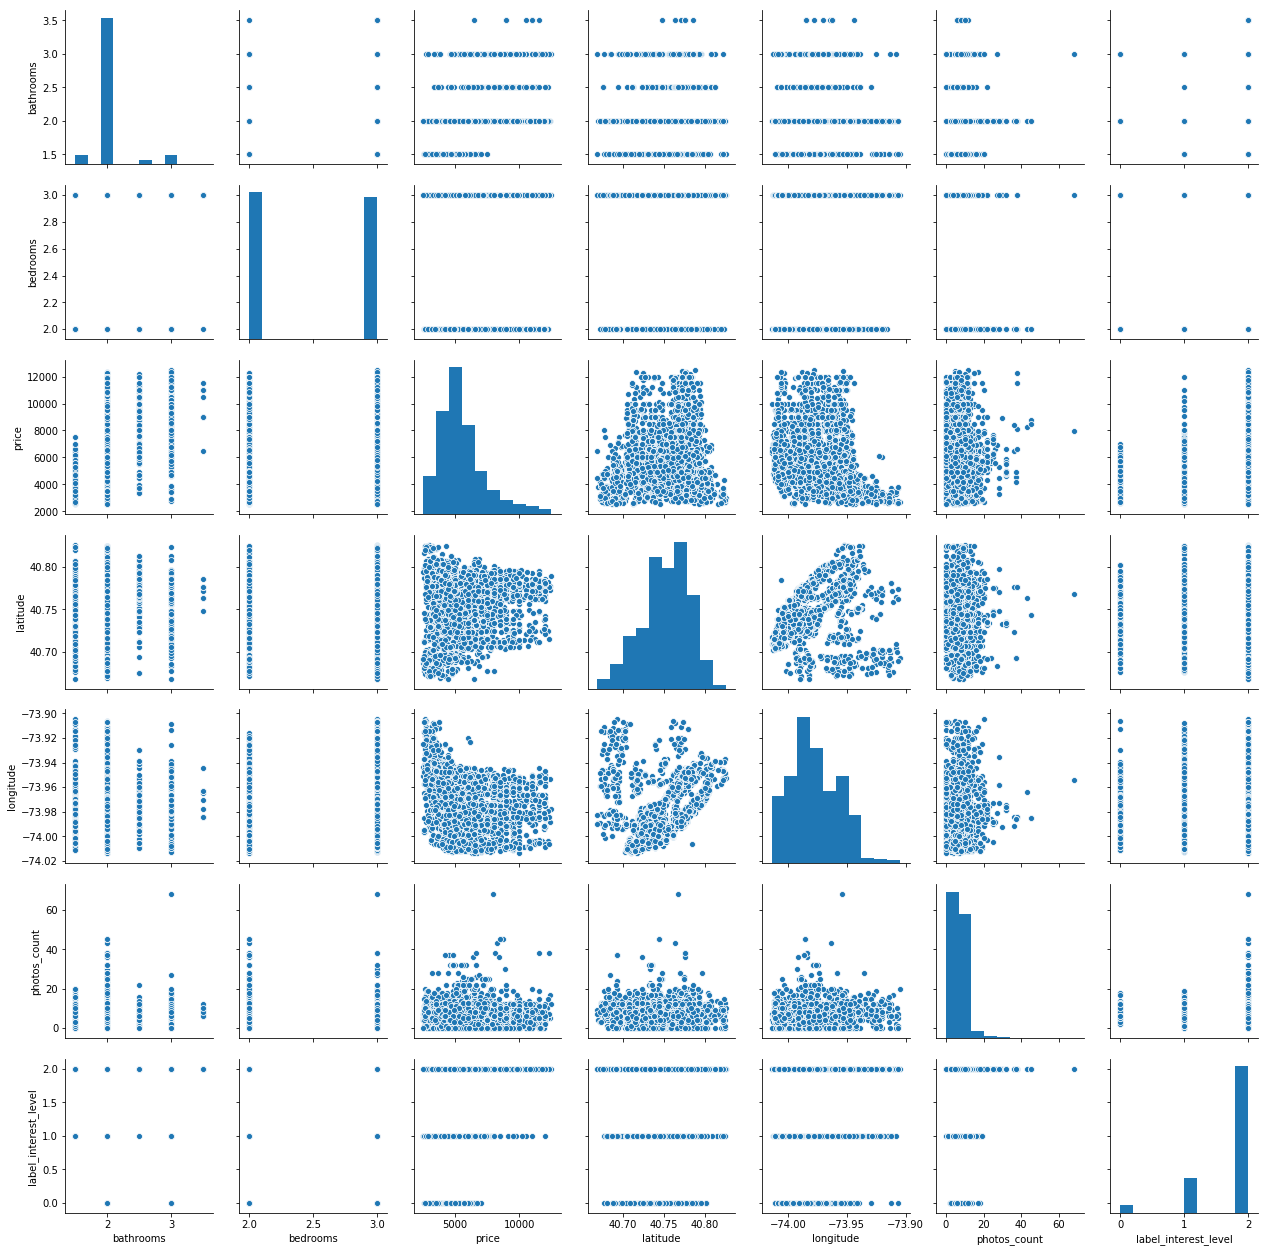

In [34]:
sns.pairplot(remove_outliers(FEATURES_TRAIN_DATAFRAME[FEATURIZED_NUMERICAL_COLUMNS],
                             NUMERICAL_QUANTILES))

We compare the validation split to the test data above to ensure that that we're sampling from a similar distribution. On the whole, we appear to be - the distribution of labels is about the same and this seems to have leaked into the distribution of proeprties geogrpahically (though the test data seems to have more properties from the northeastern peninsula). With a bit more time we probably could have tried to address this problem by also stratifying the validation split so that we included properties from that region, too.

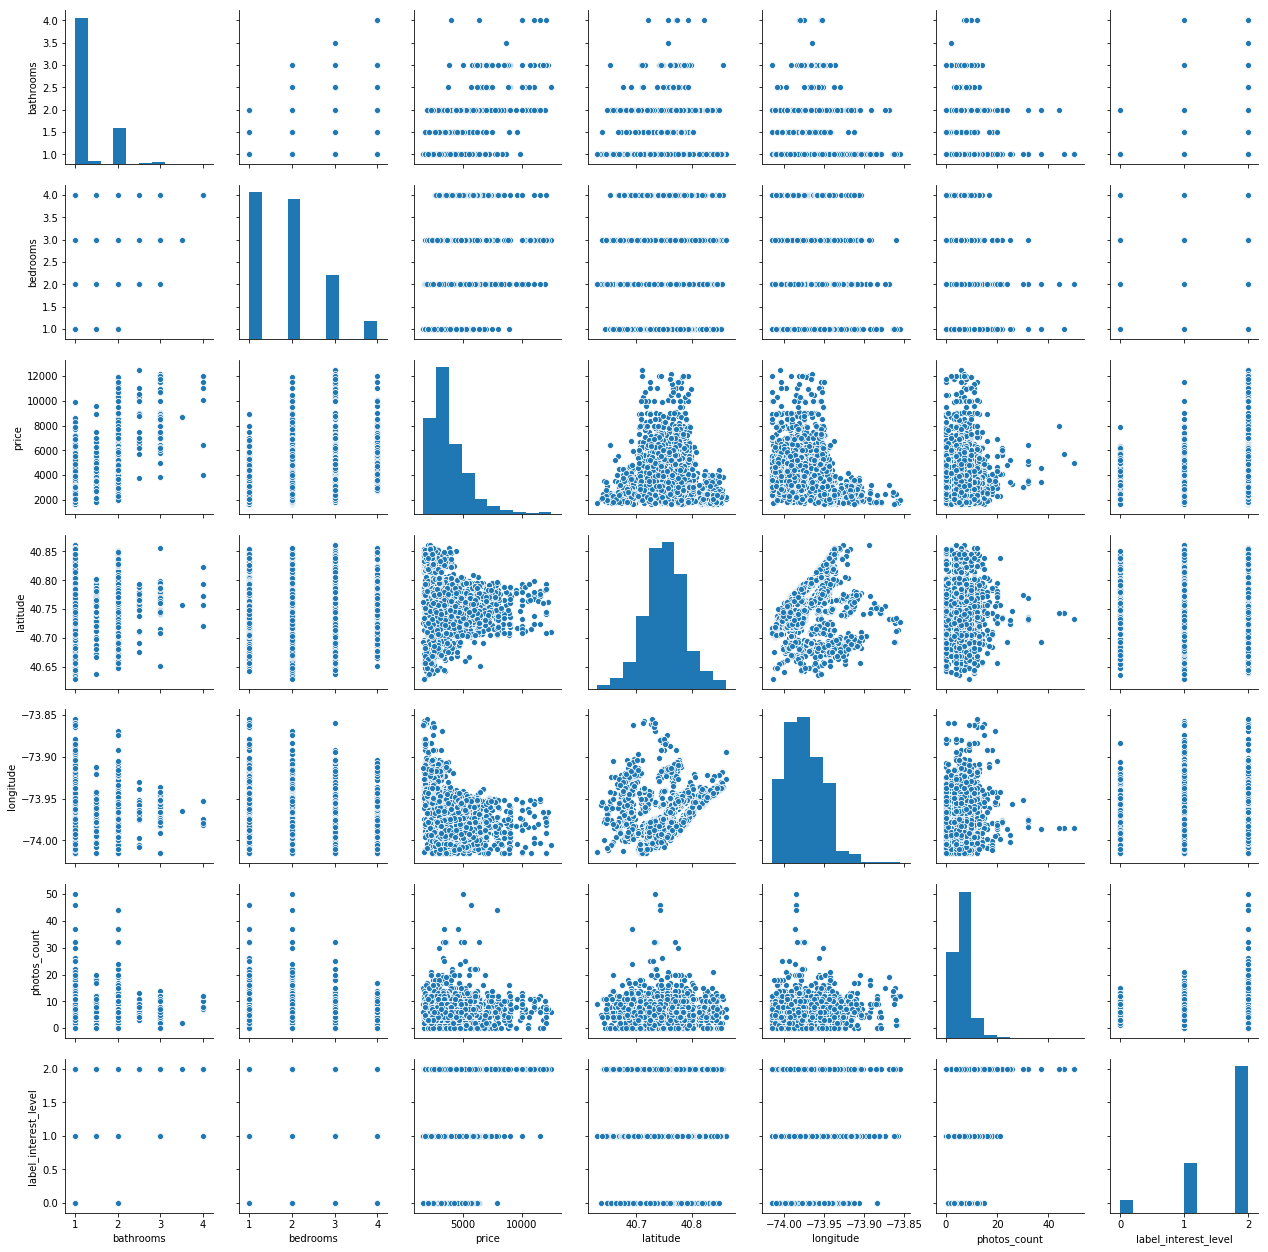

In [35]:
sns.pairplot(remove_outliers(FEATURES_VALIDATION_DATAFRAME[FEATURIZED_NUMERICAL_COLUMNS],
                             NUMERICAL_QUANTILES))

Finally, test set: we don't have the labels here (obviously), but we do have the count of photos. We get similar-ish distributions, properties with a higher photo count tend to be a little more expensive, but not much new information there.

In [ ]:
sns.pairplot(remove_outliers(FEATURES_TEST_DATAFRAME[FEATURIZED_NUMERICAL_COLUMNS[:-1]],
                             NUMERICAL_QUANTILES))

## 3) Fitting models

Now we can try out a few models and see what works well for the data that
we have so far.

In [ ]:
CATEGORICAL_FEATURES = {
    'building_id_category': len(BUILDING_CATEGORY_TO_BUILDING_ID),
    'manager_id_category': len(MANAGER_ID_TO_MANAGER_CATEGORY),
    'display_address_category': len(DISP_ADDR_ID_TO_DISP_ADDR_CATEGORY)
}

For convenience, pull out the labels for training

In [ ]:
TRAIN_LABELS = FEATURES_TRAIN_DATAFRAME['label_interest_level']
VALIDATION_LABELS = FEATURES_VALIDATION_DATAFRAME['label_interest_level']

### 3.1 Logistic Regression

This is just baseline Logistic Regression. The 'C' parameter is a regularization strength.

The 'penalty' paramter specifies the regularization penalty to be applied. 'l2' is the default, which basically
prevents any one particular weight from getting too large. 'l1' promotes sparse solutions.

In [ ]:
def train_logistic_regression_model(data_info,
                                    featurized_train_data,
                                    featurized_validation_data,
                                    train_labels,
                                    validation_labels,
                                    train_param_grid_optimal=None):
    pipeline = basic_logistic_regression_pipeline(CATEGORICAL_FEATURES,
                                                  param_grid_optimal=train_param_grid_optimal)
    pipeline.fit(featurized_train_data, train_labels)
    print("Best parameters {}".format(pipeline.best_params_))
    return search


def predict_with_sklearn_estimator(model, data):
    return model.predict(data), model.predict_proba(data)


In [ ]:
(LOGISTIC_REGRESSION_MODEL_VALIDATION_PROBABILITIES,
 LOGISTIC_REGRESSION_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS,
        VALIDATION_LABELS,
        featurize_for_tabular_models(DROP_COLUMNS, CATEGORICAL_FEATURES),
        train_logistic_regression_model,
        predict_with_sklearn_estimator,
        train_param_grid_optimal={
            'C': [1.0],
            'class_weight': [None],
            'penalty': ['l2']
        }
    )
)

In [ ]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        LOGISTIC_REGRESSION_MODEL_TEST_PROBABILITIES,
    ),
    'renthop_logistic_regression_submissions.csv'
)

### 3.2 XGBoost

XGBoost is a histogram based model that applies boosting to an ensemble of weaker learners (decision trees). It generally performs quite well on Kaggle competitions and is also another baseline to use.

In [ ]:
def train_xgboost_model(data_info,
                        featurized_train_data,
                        featurized_validation_data,
                        train_labels,
                        validation_labels,
                        train_param_grid_optimal=None):
    pipeline = basic_xgboost_pipeline(featurized_train_data,
                                      train_labels,
                                      tree_method=(
                                          # 'gpu_hist' turned out to be a lot slower
                                         'hist'
                                      ),
                                      param_grid_optimal=train_param_grid_optimal)
    pipeline.fit(featurized_train_data, train_labels)
    print("Best parameters {}".format(pipeline.best_params_))
    return pipeline

In [ ]:
(XGBOOST_MODEL_VALIDATION_PROBABILITIES,
 XGBOOST_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS,
        VALIDATION_LABELS,
        featurize_for_tree_models(DROP_COLUMNS, CATEGORICAL_FEATURES),
        train_xgboost_model,
        predict_with_sklearn_estimator,
        # Determined by Grid Search, above
        train_param_grid_optimal={
            'colsample_bytree': [1.0],
            'gamma': [1.5],
            'max_depth': [5],
            'min_child_weight': [1],
            'n_estimators': [200],
            'subsample': [0.6]
        }
    )
)

In [ ]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        XGBOOST_MODEL_TEST_PROBABILITIES,
    ),
    'xgboost_submissions.csv'
)

## 3.3 Random Forest

Random forest is basically an ensemble of lots of decision trees and we average out the results from each tree.

In [ ]:
def train_rf_model(data_info,
                   featurized_train_data,
                   featurized_validation_data,
                   train_labels,
                   validation_labels,
                   train_param_grid_optimal=None):
    pipeline = basic_random_forest_pipeline(featurized_train_data,
                                            train_labels,
                                            # Determined by Grid Search, above
                                            param_grid_optimal=train_param_grid_optimal)
    pipeline.fit(featurized_train_data, train_labels)
    print("Best parameters {}".format(pipeline.best_params_))
    return pipeline

In [ ]:
(RF_MODEL_VALIDATION_PROBABILITIES,
 RF_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS,
        VALIDATION_LABELS,
        featurize_for_tree_models(DROP_COLUMNS, CATEGORICAL_FEATURES),
        train_rf_model,
        predict_with_sklearn_estimator,
        train_param_grid_optimal={
            'bootstrap': [False],
            'max_depth': [5],
            'min_samples_leaf': [1],
            'n_estimators': [100]
        }
    )
)

## 3.4 Adaboost

In this approach, we combine several "weak" classifiers into a "strong" classifier. It is actually a meta-learning technique, though we use a decision tree as the base model.

In [ ]:
def train_adaboost_model(data_info,
                         featurized_train_data,
                         featurized_validation_data,
                         train_labels,
                         validation_labels,
                         train_param_grid_optimal=None):
    pipeline = basic_adaboost_pipeline(featurized_train_data,
                                       train_labels,
                                       # Determined by Grid Search, above
                                       param_grid_optimal=train_param_grid_optimal)
    pipeline.fit(featurized_train_data, train_labels)
    print("Best parameters {}".format(pipeline.best_params_))
    return pipeline

In [ ]:
(ADABOOST_MODEL_VALIDATION_PROBABILITIES,
 ADABOOST_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS,
        VALIDATION_LABELS,
        featurize_for_tree_models(DROP_COLUMNS, CATEGORICAL_FEATURES),
        train_adaboost_model,
        predict_with_sklearn_estimator,
        train_param_grid_optimal={
            'learning_rate': [0.1],
            'n_estimators': [100]
        }
    )
)

## 3.4 ExtraTrees

Extratrees is also another ensembling based model. It stands for "Extremely Randomized Trees". Its main property is that it reduces variance for a small incrase in bias.

In [ ]:
def train_extratrees_model(data_info,
                           featurized_train_data,
                           featurized_validation_data,
                           train_labels,
                           validation_labels,
                           train_param_grid_optimal=None):
    pipeline = basic_extratrees_pipeline(featurized_train_data,
                                         train_labels,
                                         # Determined by Grid Search, above
                                         param_grid_optimal=train_param_grid_optimal)
    pipeline.fit(featurized_train_data, train_labels)
    print("Best parameters {}".format(pipeline.best_params_))
    return pipeline

In [ ]:
(EXTRATREES_MODEL_VALIDATION_PROBABILITIES,
 EXTRATREES_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS,
        VALIDATION_LABELS,
        featurize_for_tree_models(DROP_COLUMNS, CATEGORICAL_FEATURES),
        train_extratrees_model,
        predict_with_sklearn_estimator,
        train_param_grid_optimal={
            'bootstrap': [False],
            'max_depth': [5],
            'min_samples_leaf': [1],
            'n_estimators': [200]
        }
    )
)

### 3.5 SVC

With Support Vector Machines we can make use of kernel functions in order to try and have non-linear fits on our data. For instance, below we use the radial-basis-function kernel, though it doesn't perform as well as we would like.

In [ ]:
def train_svc_model(data_info,
                    featurized_train_data,
                    featurized_validation_data,
                    train_labels,
                    validation_labels,
                    train_param_grid_optimal=None):
    pipeline = basic_svc_pipeline(featurized_train_data,
                                  train_labels,
                                  # Determined by Grid Search, above
                                  param_grid_optimal=train_param_grid_optimal)
    pipeline.fit(featurized_train_data, train_labels)
    print("Best parameters {}".format(pipeline.best_params_))
    return pipeline

In [ ]:
(SVC_MODEL_VALIDATION_PROBABILITIES,
 SVC_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS,
        VALIDATION_LABELS,
        featurize_for_tabular_models(DROP_COLUMNS, CATEGORICAL_FEATURES),
        train_svc_model,
        predict_with_sklearn_estimator,
        train_param_grid_optimal={
            'C': [1.0],
            'gamma': 'scale',
            'kernel': ['rbf']
        }
    )
)

### 3.6 Neural Net (Text Classification) Approaches

Here we leverage the actual text in the "description" field to try and do the classification, both independently and on top of the tabular data using Neural Nets with PyTorch.

Before we do that, it will be convenient to split our
data into continuous and categorical sections (as the categorical
sections will be put through independent embeddings in each
model) and tensorify some of our data, so lets do that now.

Note that the continuous data needs to be scaled to have zero mean
and unit variance - this prevents saturation of activation units
in the upper classification layers.

In [ ]:
import imp
imp.reload(utils.model)
from utils.model import rescale_features_and_split_into_continuous_and_categorical

((TRAIN_FEATURES_CONTINUOUS,
  TRAIN_FEATURES_CATEGORICAL),
 (VALIDATION_FEATURES_CONTINUOUS,
  VALIDATION_FEATURES_CATEGORICAL),
 (TEST_FEATURES_CONTINUOUS,
  TEST_FEATURES_CATEGORICAL)) = rescale_features_and_split_into_continuous_and_categorical(CATEGORICAL_FEATURES,
                                                                                           FEATURES_TRAIN_DATAFRAME,
                                                                                           FEATURES_VALIDATION_DATAFRAME,
                                                                                           FEATURES_TEST_DATAFRAME)

Now we convert the labels into tensors, but we only put the labels
on the GPU (not the rest of the data, we'd run out of memory). Skorch
will conveniently put each batch on the GPU for us, so we don't need to
worry about that.

In [ ]:
TRAIN_LABELS_TENSOR = torch.tensor(TRAIN_LABELS.values).long()
VALIDATION_LABELS_TENSOR = torch.tensor(VALIDATION_LABELS.values).long()

In [ ]:
TRAIN_FEATURES_CONTINUOUS_TENSOR = torch.tensor(TRAIN_FEATURES_CONTINUOUS).float()
TRAIN_FEATURES_CATEGORICAL_TENSOR = torch.tensor(TRAIN_FEATURES_CATEGORICAL).long()

In [ ]:
VALIDATION_FEATURES_CONTINUOUS_TENSOR = torch.tensor(VALIDATION_FEATURES_CONTINUOUS).float()
VALIDATION_FEATURES_CATEGORICAL_TENSOR = torch.tensor(VALIDATION_FEATURES_CATEGORICAL).long()

In [ ]:
TEST_FEATURES_CONTINUOUS_TENSOR = torch.tensor(TEST_FEATURES_CONTINUOUS).float()
TEST_FEATURES_CATEGORICAL_TENSOR = torch.tensor(TEST_FEATURES_CATEGORICAL).long()

#### 3.6.1 Simple RNN/LSTM

Before we start putting our data into the RNN, lets tokenize our descriptions. In order to do this we'll be using fastai's Tokenizer class. We can preview the result of tokenization below

In [ ]:
preview_tokenization(TRAIN_DATAFRAME["description"][:10])

Now we need to encode our tokens as **padded** sequences of integers such that we have a matrix of length [n $\times$ max_len].

To start our with, PyTorch takes one-hot encoded data as a single array of integers, where each integer specifies the index into some sparse vector where a $1$ will be set. Of course, if you have such sparse vectors, you can save a lot of time on the multiplication by just picking the right dimension and ignoring all the zero ones, which is exactly what happens internally.

The reason why we need padding is for computational efficiency reasons - we want to push a large batch of sentences on to the GPU for parallel computation all, but in order for this to work we need to pass the GPU a big square matrix. This means that the matrix will have at least as many columns as the maximum number of tokens in a sentence, where every other shorter sentence will be padded by a special "<PAD>" token. We also keep the length of every unpadded sentence in a separate vector - we'll see later that this is used by torch as an optimization to prevent the RNN from running over all the padding tokens within a batch.

In [ ]:
preview_encoded_sentences(TRAIN_DATAFRAME["description"][:10])

Here we roll our own simple LSTM classifier using Skorch and PyTorch.

The `SimpleRNNPredictor` model just takes a batch of encoded word-encoded
sentences and runs them through a Bi-LSTM, then has a fully connected
layer sitting on top of the final "hidden" output of the LSTM (think
of the hidden state being passed through the LSTM along with each encoded input for the entire sentence all the way up to the sentence length). Then we just predict the class based on the final hidden state.

What Skorch does here is it implements the training loop, allows us
to add "hooks" (for instance, scoring on every epoch, a progress bar,
checkpointing so that we only keep our best model by validation loss,
cyclic learning rate scheduling and learning rate annealing (we reduce the learning rate if our validation loss is not going down)). It also wraps the model in an sklearn estimator-like API, so we can use it just like any other estimator.

Note that the NoToTensorInLossClassifier implements a few fixes on top
of NeuralNetClassifier - in particular `predict_proba` takes the exponent of the returned probabilities since we return log-softmax probabilities that get passed to `NLLLoss`.

In [ ]:
def featurize_for_rnn_language_model(*dataframes):
    data_info, model_datasets = featurize_sequences_from_dataframe(*dataframes)
    return data_info, model_datasets


def train_rnn_model(data_info,
                    featurized_train_data,
                    featurized_validation_data,
                    train_labels,
                    validation_labels,
                    train_param_grid_optimal=None):
    word_to_one_hot, one_hot_to_word = data_info
    train_word_description_sequences, train_word_sequences_lengths = featurized_train_data
    model = NoToTensorInLossClassifier(
        SimpleRNNPredictor,
        module__encoder_dimension=100, # Number of encoder features
        module__hidden_dimension=50, # Number of hidden features
        module__dictionary_dimension=len(one_hot_to_word), # Dictionary dimension
        module__output_dimension=3,
        module__dropout=0.1,
        lr=1e-2,
        batch_size=256,
        optimizer=optim.Adam,
        max_epochs=4,
        module__layers=2,
        train_split=simple_train_test_split_without_shuffle_func(0.3),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        callbacks=[
            SummarizeParameters(),
            EpochScoring(scoring='accuracy'),
            LRAnnealing(),
            LRScheduler(),
            ProgressBar(),
            CheckpointAndKeepBest(dirname='rnn_lang_checkpoint'),
            TrainEndCheckpoint(dirname='rnn_lang_checkpoint',
                               fn_prefix='rnn_train_end_')
        ]
    )
    model.fit((train_word_description_sequences,
               train_word_sequences_lengths),
              maybe_cuda(train_labels))
    
    return model

In [ ]:
(SIMPLE_RNN_MODEL_VALIDATION_PROBABILITIES,
 SIMPLE_RNN_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS_TENSOR,
        VALIDATION_LABELS_TENSOR,
        featurize_for_rnn_language_model,
        train_rnn_model,
        predict_with_sklearn_estimator
    )
)

In [ ]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        SIMPLE_RNN_MODEL_TEST_PROBABILITIES,
    ),
    'simple_rnn_model_submissions.csv'
)

In [ ]:
def splice_into_datasets(datasets, append):
    return tuple(list(d) + list(a) for d, a in zip(datasets, append))

def featurize_for_rnn_tabular_model(*dataframes):
    data_info, model_datasets = featurize_sequences_from_dataframe(*dataframes)
    # Need to wrap each dataset in outer list so that splicing works correctly
    return data_info, splice_into_datasets(model_datasets,
                                           ((TRAIN_FEATURES_CONTINUOUS_TENSOR,
                                             TRAIN_FEATURES_CATEGORICAL_TENSOR),
                                            (VALIDATION_FEATURES_CONTINUOUS_TENSOR,
                                             VALIDATION_FEATURES_CATEGORICAL_TENSOR),
                                            (TEST_FEATURES_CONTINUOUS_TENSOR,
                                             TEST_FEATURES_CATEGORICAL_TENSOR )))


def train_rnn_tabular_model(data_info,
                            featurized_train_data,
                            featurized_validation_data,
                            train_labels,
                            validation_labels,
                            train_param_grid_optimal=None):
    word_to_one_hot, one_hot_to_word = data_info
    _, _, train_continuous, train_categorical = featurized_train_data
    model = NoToTensorInLossClassifier(
        SimpleRNNTabularDataPredictor,
        module__encoder_dimension=100, # Number of encoder features
        module__hidden_dimension=50, # Number of hidden features
        module__dictionary_dimension=len(one_hot_to_word), # Dictionary dimension
        module__output_dimension=3,
        module__dropout=0.1,
        module__continuous_features_dimension=train_continuous.shape[1],
        module__categorical_feature_embedding_dimensions=[
            (CATEGORICAL_FEATURES[c], 80) for c in CATEGORICAL_FEATURES
        ],
        lr=1e-2,
        batch_size=256,
        optimizer=optim.Adam,
        max_epochs=4,
        module__layers=2,
        train_split=simple_train_test_split_without_shuffle_func(0.3),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        callbacks=[
            SummarizeParameters(),
            EpochScoring(scoring='accuracy'),
            LRAnnealing(),
            LRScheduler(),
            ProgressBar(),
            CheckpointAndKeepBest(dirname='rnn_lang_checkpoint'),
            TrainEndCheckpoint(dirname='rnn_lang_checkpoint',
                               fn_prefix='rnn_train_end_')
        ]
    )
    model.fit(featurized_train_data, maybe_cuda(train_labels))
    
    return model

In [ ]:
(SIMPLE_RNN_TABULAR_MODEL_VALIDATION_PROBABILITIES,
 SIMPLE_RNN_TABULAR_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS_TENSOR,
        VALIDATION_LABELS_TENSOR,
        featurize_for_rnn_tabular_model,
        train_rnn_tabular_model,
        predict_with_sklearn_estimator
    )
)

In [ ]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        SIMPLE_RNN_TABULAR_MODEL_TEST_PROBABILITIES,
    ),
    'simple_rnn_model_tabular_data_submissions.csv'
)

### 3.6.1 FastText

A key concept here is that we compute the bigrams of a sentence and then apply them to the end of the sentence.

Then we just put the whole thing through linear layers after average pooling, the average pooling takes into account the big-grams.

In [ ]:
def featurize_dataframe_sequences_for_fasttext(*dataframes):
    sequences_lists = tokenize_sequences(
        *tuple(list(df['clean_description']) for df in dataframes)
    )

    text = torchtext_create_text_vocab(*sequences_lists,
                                       vectors='glove.6B.100d')
    
    return text, torchtext_process_texts(*postprocess_sequences(
        *sequences_lists,
        postprocessing=generate_bigrams
    ), text=text)


def train_fasttext_model(data_info,
                         featurized_train_data,
                         featurized_validation_data,
                         train_labels,
                         validation_labels,
                         train_param_grid_optimal=None):
    embedding_dim = 100
    model = NoToTensorInLossClassifier(
        FastText,
        lr=0.001,
        batch_size=256,
        optimizer=optim.Adam,
        callbacks=[
            SummarizeParameters(),
            EpochScoring(scoring='accuracy'),
            LRAnnealing(),
            LRScheduler(),
            ProgressBar(),
            CheckpointAndKeepBest(dirname='fasttext_checkpoint'),
            TrainEndCheckpoint(dirname='fasttext_tabular_checkpoint',
                               fn_prefix='fasttext_train_end_')
        ],
        max_epochs=6,
        train_split=shuffled_train_test_split_by_indices(0.3),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        module__encoder_dimension=embedding_dim, # Number of encoder features
        module__dictionary_dimension=len(data_info.vocab.itos), # Dictionary dimension
        module__output_dimension=3,
        module__dropout=0.8,
        module__pretrained=data_info.vocab.vectors
    )
    model.fit(featurized_train_data, maybe_cuda(train_labels))
    return model

In [ ]:
(FASTTEXT_MODEL_VALIDATION_PROBABILITIES,
 FASTTEXT_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS_TENSOR,
        VALIDATION_LABELS_TENSOR,
        featurize_dataframe_sequences_for_fasttext,
        train_fasttext_model,
        predict_with_sklearn_estimator
    )
)

In [ ]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        FASTTEXT_MODEL_TEST_PROBABILITIES,
    ),
    'fasttext_model_submissions.csv'
)

In [ ]:
def featurize_for_fasttext_tabular_model(*dataframes):
    data_info, model_datasets = featurize_dataframe_sequences_for_fasttext(*dataframes)
    # Need to wrap each dataset in outer list so that splicing works correctly
    return data_info, splice_into_datasets(tuple([x] for x in model_datasets),
                                           ((TRAIN_FEATURES_CONTINUOUS_TENSOR,
                                             TRAIN_FEATURES_CATEGORICAL_TENSOR),
                                            (VALIDATION_FEATURES_CONTINUOUS_TENSOR,
                                             VALIDATION_FEATURES_CATEGORICAL_TENSOR),
                                            (TEST_FEATURES_CONTINUOUS_TENSOR,
                                             TEST_FEATURES_CATEGORICAL_TENSOR)))


def train_fasttext_tabular_model(data_info,
                                 featurized_train_data,
                                 featurized_validation_data,
                                 train_labels,
                                 validation_labels,
                                 train_param_grid_optimal=None):
    embedding_dim = 100
    _, train_features_continuous, _ = featurized_train_data
    model = NoToTensorInLossClassifier(
        FastTextWithTabularData,
        lr=0.001,
        batch_size=256,
        optimizer=optim.Adam,
        callbacks=[
            SummarizeParameters(),
            EpochScoring(scoring='accuracy'),
            LRAnnealing(),
            LRScheduler(),
            ProgressBar(),
            CheckpointAndKeepBest(dirname='fasttext_checkpoint'),
            TrainEndCheckpoint(dirname='fasttext_tabular_checkpoint',
                               fn_prefix='fasttext_train_end_')
        ],
        max_epochs=6,
        train_split=shuffled_train_test_split_by_indices(0.3),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        module__encoder_dimension=embedding_dim, # Number of encoder features
        module__dictionary_dimension=len(data_info.vocab.itos), # Dictionary dimension
        module__output_dimension=3,
        module__dropout=0.8,
        module__pretrained=data_info.vocab.vectors,
        module__continuous_features_dimension=train_features_continuous.shape[1],
        module__categorical_feature_embedding_dimensions=[
            (CATEGORICAL_FEATURES[c], 80) for c in CATEGORICAL_FEATURES
        ],
    )
    model.fit(featurized_train_data, maybe_cuda(train_labels))
    return model

In [ ]:
(FASTTEXT_TABULAR_MODEL_VALIDATION_PROBABILITIES,
 FASTTEXT_TABULAR_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS_TENSOR,
        VALIDATION_LABELS_TENSOR,
        featurize_for_fasttext_tabular_model,
        train_fasttext_tabular_model,
        predict_with_sklearn_estimator
    )
)

In [ ]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        FASTTEXT_TABULAR_MODEL_TEST_PROBABILITIES,
    ),
    'fasttext_tabular_model_submissions.csv'
)

### 3.6.3 TextCNN
Here we use a convolutional neural network on the text.

We kind of have to think of text like an "image". The horizontal
dimension is just each sentence (of variable length, but they all have
padding at the end). Then on the vertical axis, we have the word vectors
and we move our window across. Idea here is that similar to images, the
order between words and between word vector components probably matters,
so we take into account conceptual space and sentence space in the text
image domain.

In [ ]:
def featurize_dataframe_sequences_for_textcnn(*dataframes):
    sequences_lists = tokenize_sequences(
        *tuple(list(df['clean_description']) for df in dataframes)
    )

    text = torchtext_create_text_vocab(*sequences_lists,
                                       vectors='glove.6B.100d')
    
    return text, tuple(text.process(sl).transpose(0, 1) for sl in sequences_lists)

def train_textcnn_model(data_info,
                        featurized_train_data,
                        featurized_validation_data,
                        train_labels,
                        validation_labels,
                        train_param_grid_optimal=None):
    embedding_dim = 100
    model = NoToTensorInLossClassifier(
        TextCNN,
        lr=0.001,
        batch_size=64,
        optimizer=optim.Adam,
        callbacks=[
            SummarizeParameters(),
            EpochScoring(scoring='accuracy'),
            LRAnnealing(),
            LRScheduler(),
            ProgressBar(),
            CheckpointAndKeepBest(dirname='textcnn_checkpoint'),
            TrainEndCheckpoint(dirname='textcnn_tabular_checkpoint',
                               fn_prefix='textcnn_train_end_')
        ],
        max_epochs=10,
        train_split=shuffled_train_test_split_by_indices(0.3),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        module__encoder_dimension=embedding_dim, # Number of encoder features
        module__dictionary_dimension=len(data_info.vocab.itos), # Dictionary dimension
        module__output_dimension=3,
        module__n_filters=10,
        module__filter_sizes=(3, 4, 5),
        module__dropout=0.8,
        module__pretrained=data_info.vocab.vectors
    )
    model.fit(featurized_train_data, maybe_cuda(train_labels))
    return model

In [ ]:
(TEXTCNN_MODEL_VALIDATION_PROBABILITIES,
 TEXTCNN_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS_TENSOR,
        VALIDATION_LABELS_TENSOR,
        featurize_dataframe_sequences_for_textcnn,
        train_textcnn_model,
        predict_with_sklearn_estimator
    )
)

In [ ]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        TEXTCNN_MODEL_TEST_PROBABILITIES,
    ),
    'textcnn_model_submissions.csv'
)

In [ ]:
def featurize_dataframes_for_textcnn_tabular_model(*dataframes):
    data_info, model_datasets = featurize_dataframe_sequences_for_textcnn(*dataframes)
    return data_info, splice_into_datasets(tuple([x] for x in model_datasets),
                                           ((TRAIN_FEATURES_CONTINUOUS_TENSOR,
                                             TRAIN_FEATURES_CATEGORICAL_TENSOR),
                                            (VALIDATION_FEATURES_CONTINUOUS_TENSOR,
                                             VALIDATION_FEATURES_CATEGORICAL_TENSOR),
                                            (TEST_FEATURES_CONTINUOUS_TENSOR,
                                             TEST_FEATURES_CATEGORICAL_TENSOR)))

def train_textcnn_tabular_model(data_info,
                                featurized_train_data,
                                featurized_validation_data,
                                train_labels,
                                validation_labels,
                                train_param_grid_optimal=None):
    embedding_dim = 100
    _, train_features_continuous, _ = featurized_train_data
    model = NoToTensorInLossClassifier(
        TextCNNWithTabularData,
        lr=0.001,
        batch_size=256,
        optimizer=optim.Adam,
        callbacks=[
            SummarizeParameters(),
            EpochScoring(scoring='accuracy'),
            LRAnnealing(),
            LRScheduler(),
            ProgressBar(),
            CheckpointAndKeepBest(dirname='fasttext_checkpoint'),
            TrainEndCheckpoint(dirname='fasttext_tabular_checkpoint',
                               fn_prefix='fasttext_train_end_')
        ],
        max_epochs=10,
        train_split=shuffled_train_test_split_by_indices(0.3),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        module__encoder_dimension=embedding_dim, # Number of encoder features
        module__dictionary_dimension=len(data_info.vocab.itos), # Dictionary dimension
        module__output_dimension=3,
        module__n_filters=100,
        module__filter_sizes=(3, 4, 5),
        module__dropout=0.8,
        module__pretrained=data_info.vocab.vectors,
        module__continuous_features_dimension=train_features_continuous.shape[1],
        module__categorical_feature_embedding_dimensions=[
            (CATEGORICAL_FEATURES[c], 80) for c in CATEGORICAL_FEATURES
        ],
    )
    model.fit(featurized_train_data, maybe_cuda(train_labels))
    return model

In [ ]:
(TEXTCNN_TABULAR_MODEL_VALIDATION_PROBABILITIES,
 TEXTCNN_TABULAR_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS_TENSOR,
        VALIDATION_LABELS_TENSOR,
        featurize_dataframes_for_textcnn_tabular_model,
        train_textcnn_tabular_model,
        predict_with_sklearn_estimator
    )
)

In [ ]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        TEXTCNN_TABULAR_MODEL_TEST_PROBABILITIES,
    ),
    'textcnn_tabular_model_submissions.csv'
)

### 3.6.4 BERT

BERT is a big ol' attentional model.

We use the pretrained version of BERT (eg `bert-base-uncased`) and the
corresponding tokenizer - `bert_featurize_dataframe` reads from
`clean_description` in the dataframe and tokenizes sentences in the
same way that the pre-trained model was tokenized and should in principle
do the word vector mapping for us.

Essentially what we are doing here is fine-tuning the classification
layers of BERT.

In [ ]:
BERT_MODEL = 'bert-base-uncased'


def featurize_bert_lang_features(*dataframes):
    return _, tuple(
        tuple(torch.stack(x) for x in zip(*features))
        for features in bert_featurize_data_frames(BERT_MODEL, *dataframes)
    )
        

def train_bert_lang_model(data_info,
                          featurized_train_data,
                          featurized_validation_data,
                          train_labels,
                          validation_labels,
                          train_param_grid_optimal=None):
    model = BertClassifier(
        module=create_bert_model(BERT_MODEL, 3),
        optimizer__warmup=WARMUP_PROPORTION,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        optimizer=BertAdam,
        lr=6e-5,
        len_train_data=int(len(featurized_train_data[0])),
        num_labels=3,
        batch_size=16,
        train_split=shuffled_train_test_split_by_indices(0.1),
        callbacks=[
            SummarizeParameters(),
            EpochScoring(scoring='accuracy'),
            ProgressBar(),
            CheckpointAndKeepBest(dirname='bert_lang_checkpoint')
        ],
    )
    # As sugested by Maksad, need to do a hyperparameter search
    # here to get good results.
    param_grid = {
        "batch_size": [16, 32],
        "lr": [6e-5, 3e-5, 3e-5, 2e-5],
        "max_epochs": [3, 4]
    }
    search = GridSearchCV(model,
                          param_grid,
                          cv=2,
                          refit=False,
                          scoring=make_scorer(log_loss,
                                              greater_is_better=False,
                                              needs_proba=True))
    search.fit(TensorTuple(featurized_train_data), train_labels)

    print('Best params {}'.format(search.best_params_))
    # Now re-fit the estimator manually, using the best params -
    # we do this manually since we need a different view over
    # the training data to make it work
    best = clone(search.estimator, safe=True).set_params(**search.best_params_)
    best.fit(featurized_train_data, train_labels)
    return best

In [ ]:
(BERT_LANG_MODEL_VALIDATION_PROBABILITIES,
 BERT_LANG_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS,
        VALIDATION_LABELS,
        featurize_bert_lang_features,
        train_bert_lang_model,
        predict_with_sklearn_estimator
    )
)

In [ ]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        BERT_LANG_MODEL_TEST_PROBABILITIES,
    ),
    'bert_model_submissions.csv'
)

In [ ]:
def featurize_bert_tabular_features(*dataframes):
    model_datasets = splice_into_datasets(tuple([x] for x in bert_featurize_data_frames(BERT_MODEL, *dataframes)),
                                          ((TRAIN_FEATURES_CONTINUOUS_TENSOR,
                                            TRAIN_FEATURES_CATEGORICAL_TENSOR),
                                           (VALIDATION_FEATURES_CONTINUOUS_TENSOR,
                                            VALIDATION_FEATURES_CATEGORICAL_TENSOR),
                                           (TEST_FEATURES_CONTINUOUS_TENSOR,
                                            TEST_FEATURES_CATEGORICAL_TENSOR)))
    return _, tuple(
        tuple(torch.stack(x) for x in zip(*[
            tuple(list(bert_features) + [continuous, categorical])
            for bert_features, continuous, categorical in zip(features,
                                                              continuous_tensor,
                                                              categorical_tensor)
        ]))
        for features, continuous_tensor, categorical_tensor in model_datasets
    )


def train_bert_tabular_model(data_info,
                             featurized_train_data,
                             featurized_validation_data,
                             train_labels,
                             validation_labels,
                             train_param_grid_optimal=None):
    batch_size = 16
    _, _, _, continuous_features, categorical_features = featurized_train_data
    model = BertClassifier(
        module=create_bert_model_with_tabular_features(
            BERT_MODEL,
            continuous_features.shape[1],
            [
                (CATEGORICAL_FEATURES[c], 80) for c in CATEGORICAL_FEATURES
            ],
            3
        ),
        len_train_data=int(len(featurized_train_data[0])),
        optimizer__warmup=WARMUP_PROPORTION,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        optimizer=BertAdam,
        num_labels=3,
        batch_size=batch_size,
        train_split=shuffled_train_test_split_by_indices(0.3),
        callbacks=[
            SummarizeParameters(),
            EpochScoring(scoring='accuracy'),
            ProgressBar(),
            CheckpointAndKeepBest(dirname='bert_lang_checkpoint')
        ],
    )
    model.fit(featurized_train_data, train_labels)
    
    # As sugested by Maksad, need to do a hyperparameter search
    # here to get good results.
    param_grid = {
        "batch_size": [16, 32],
        "lr": [6e-5, 3e-5, 3e-5, 2e-5],
        "max_epochs": [3, 4]
    }
    search = GridSearchCV(model,
                          param_grid,
                          cv=2,
                          refit=False,
                          scoring=make_scorer(log_loss,
                                              greater_is_better=False,
                                              needs_proba=True))
    search.fit(TensorTuple(featurized_train_data), train_labels)
    
    print('Best params {}'.format(search.best_params_))
    # Now re-fit the estimator manually, using the best params -
    # we do this manually since we need a different view over
    # the training data to make it work
    best = clone(search.estimator, safe=True).set_params(**search.best_params_)
    best.fit(featurized_train_data, train_labels)
    return best

In [ ]:
(BERT_TABULAR_MODEL_VALIDATION_PROBABILITIES,
 BERT_TABULAR_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS_TENSOR,
        VALIDATION_LABELS_TENSOR,
        featurize_bert_tabular_features,
        train_bert_tabular_model,
        predict_with_sklearn_estimator
    )
)

In [ ]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        BERT_TABULAR_MODEL_TEST_PROBABILITIES,
    ),
    'bert_tabular_model_submissions.csv'
)

### 3.6.5 ULMFiT
This is basically transfer learning onto an AWD-LSTM (used by fastai).

We have to use the fastai API here directly, since the best
implementation I found of this was by Jeremy Howard himself.

Note before we ran the notebook, we used `train_lm.py` (pointing it
to the training data) to fine-tune the existing language model,
which in principle is good at English (WikiText-103) and made transferred
what we knew about English word prediction to predicting RentHop
descriptions, fine tuning on the RentHop description task. This is
different from just using word vectors, since you get the benefit
of the entire language model and contextual information, not just
the vectors themselves.

It is critical here that we load the same vocabulary used to fine
tune the network into the model when we load in the weights. Also,
we need to do the train-test split ourselves, because there
is a bug in the library where the vocabulary is only computed
on the training set and not the validation set, meaning that if the
splits are random you could miss words.

Unfortunately, the fastai API is very involved, making it difficult
to wrap with skortch without breaking stuff, so we have to use it
in a slightly different way to do the same thing. We can also only
report statistics on the first batch, hopefully that should be enough.

In [ ]:
(ULMFIT_VALIDATION_PROBABILITIES,
 ULMFIT_TEST_PROBABILITIES) = train_ulmfit_model_and_get_validation_and_test_set_predictions(
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME
)

In [ ]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        ULMFIT_TEST_PROBABILITIES
    ),
    'ulmfit_submissions.csv'
)

### 4 Ensembling

Now that we have all of our models and various predictions, we can
ensemble them together in the form of one big logistic regression model or gradient boosted tree to work out what the "true" classes are based on how all the different models were voting.

Notice that the confusion matrix for each of the models was quite
different - this indicates that each model is probably more biased towards certain features. We can get the predictions for all of our training data and put them together into another dataset which we then apply XGBoost and a linear model to. In principle this allows us to decide amongst the learners by comparing their probability distributions.

We also only do the stacking on the validation set by splitting the validation set again into training and validation data - we don't use the  original training data since that's what the learners themselves were trained on.

In [ ]:
(STACKED_VALIDATION_PREDICTIONS_TRAINING_SET,
 STACKED_VALIDATION_PREDICTIONS_VALIDATION_SET,
 _,
 VALIDATION_SPLIT_VALIDATION_DATAFRAME,
 TRAINING_SPLIT_FEATURES_VALIDATION_DATAFRAME,
 VALIDATION_SPLIT_FEATURES_VALIDATION_DATAFRAME,
 STACKED_VALIDATION_PREDICTIONS_LABELS_TRAINING_SET,
 STACKED_VALIDATION_PREDICTIONS_LABELS_VALIDATION_SET) = train_test_split(
    np.column_stack([
        LOGISTIC_REGRESSION_MODEL_VALIDATION_PROBABILITIES,
        XGBOOST_MODEL_VALIDATION_PROBABILITIES,
        ADABOOST_MODEL_VALIDATION_PROBABILITIES,
        EXTRATREES_MODEL_VALIDATION_PROBABILITIES,
        SVC_MODEL_VALIDATION_PROBABILITIES,
        SIMPLE_RNN_MODEL_VALIDATION_PROBABILITIES,
        SIMPLE_RNN_TABULAR_MODEL_VALIDATION_PROBABILITIES,
        FASTTEXT_MODEL_VALIDATION_PROBABILITIES,
        FASTTEXT_TABULAR_MODEL_VALIDATION_PROBABILITIES,
        TEXTCNN_MODEL_VALIDATION_PROBABILITIES,
        TEXTCNN_TABULAR_MODEL_VALIDATION_PROBABILITIES,
        BERT_LANG_MODEL_VALIDATION_PROBABILITIES,
        BERT_TABULAR_MODEL_VALIDATION_PROBABILITIES,
        ULMFIT_VALIDATION_PROBABILITIES,
        ULMFIT_VALIDATION_PROBABILITIES,
    ]),
    VALIDATION_DATAFRAME,
    FEATURES_VALIDATION_DATAFRAME,
    VALIDATION_LABELS,
    stratify=VALIDATION_LABELS,
    test_size=0.1
)

STACKED_TEST_PREDICTIONS_TEST_SET = np.column_stack([
    LOGISTIC_REGRESSION_MODEL_TEST_PROBABILITIES,
    XGBOOST_MODEL_TEST_PROBABILITIES,
    RF_MODEL_TEST_PROBABILITIES,
    ADABOOST_MODEL_TEST_PROBABILITIES,
    EXTRATREES_MODEL_TEST_PROBABILITIES,
    SVC_MODEL_TEST_PROBABILITIES,
    SIMPLE_RNN_MODEL_TEST_PROBABILITIES,
    SIMPLE_RNN_TABULAR_MODEL_TEST_PROBABILITIES,
    FASTTEXT_MODEL_TEST_PROBABILITIES,
    FASTTEXT_TABULAR_MODEL_TEST_PROBABILITIES,
    TEXTCNN_MODEL_TEST_PROBABILITIES,
    TEXTCNN_TABULAR_MODEL_TEST_PROBABILITIES,
    BERT_LANG_MODEL_TEST_PROBABILITIES,
    BERT_TABULAR_MODEL_TEST_PROBABILITIES,
    ULMFIT_TEST_PROBABILITIES,
    ULMFIT_TEST_PROBABILITIES,
])

### 4.1 Ensembling with XGBoost

In [ ]:
def identity_unpack(*args):
    return _, args

(XGBOOST_MODEL_STACKED_VALIDATION_PROBABILITIES,
 XGBOOST_MODEL_STACKED_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        pd.DataFrame(STACKED_VALIDATION_PREDICTIONS_TRAINING_SET),
        pd.DataFrame(STACKED_VALIDATION_PREDICTIONS_VALIDATION_SET),
        pd.DataFrame(STACKED_TEST_PREDICTIONS_TEST_SET),
        VALIDATION_SPLIT_VALIDATION_DATAFRAME,
        STACKED_VALIDATION_PREDICTIONS_LABELS_TRAINING_SET.reset_index(drop=True)['label_interest_level'],
        STACKED_VALIDATION_PREDICTIONS_LABELS_VALIDATION_SET.reset_index(drop=True)['label_interest_level'],
        identity_unpack,
        train_xgboost_model,
        predict_with_sklearn_estimator
    )
)

In [ ]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        XGBOOST_MODEL_STACKED_TEST_PROBABILITIES
    ),
    'xgboost_stacked_submissions.csv'
)

### 4.2 Ensembling with Logistic Regression

In [ ]:
(LOGISTIC_REGRESSION_MODEL_STACKED_VALIDATION_PROBABILITIES,
 LOGISTIC_REGRESSION_MODEL_STACKED_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        pd.DataFrame(STACKED_VALIDATION_PREDICTIONS_TRAINING_SET),
        pd.DataFrame(STACKED_VALIDATION_PREDICTIONS_VALIDATION_SET),
        pd.DataFrame(STACKED_TEST_PREDICTIONS_TEST_SET),
        VALIDATION_SPLIT_VALIDATION_DATAFRAME,
        STACKED_VALIDATION_PREDICTIONS_LABELS_TRAINING_SET.reset_index(drop=True)['label_interest_level'],
        STACKED_VALIDATION_PREDICTIONS_LABELS_VALIDATION_SET.reset_index(drop=True)['label_interest_level'],
        identity_unpack,
        train_logistic_regression_model,
        predict_with_sklearn_estimator
    )
)

In [ ]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        LOGISTIC_REGRESSION_MODEL_STACKED_TEST_PROBABILITIES
    ),
    'logistic_stacked_submissions.csv'
)

### 4.3 Guided Ensembles

We can also try to "guide" the ensembles by concatenating our features and then doing predictions based on that.

Unfortunately this seems to be more of a distraction than a help - we actually perform *worse* on validation set once we start introducing our original data back in.

#### 4.3.1 Guided Ensemble - XGBoost

In [ ]:
(GUIDED_XGBOOST_MODEL_STACKED_VALIDATION_PROBABILITIES,
 GUIDED_XGBOOST_MODEL_STACKED_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        pd.concat((pd.DataFrame(STACKED_VALIDATION_PREDICTIONS_TRAINING_SET),
                   TRAINING_SPLIT_FEATURES_VALIDATION_DATAFRAME.reset_index().drop(["index"], axis=1)), axis=1),
        pd.concat((pd.DataFrame(STACKED_VALIDATION_PREDICTIONS_VALIDATION_SET),
                   VALIDATION_SPLIT_FEATURES_VALIDATION_DATAFRAME.reset_index().drop(["index"], axis=1)), axis=1),
        pd.concat((pd.DataFrame(STACKED_TEST_PREDICTIONS_TEST_SET),
                   FEATURES_TEST_DATAFRAME.reset_index().drop("index", axis=1)), axis=1),
        VALIDATION_SPLIT_VALIDATION_DATAFRAME,
        STACKED_VALIDATION_PREDICTIONS_LABELS_TRAINING_SET.reset_index(drop=True)['label_interest_level'],
        STACKED_VALIDATION_PREDICTIONS_LABELS_VALIDATION_SET.reset_index(drop=True)['label_interest_level'],
        featurize_for_xgboost,
        train_xgboost_model,
        predict_with_sklearn_estimator
    )
)

In [ ]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        GUIDED_XGBOOST_MODEL_STACKED_TEST_PROBABILITIES
    ),
    'guided_xgboost_stacked_submissions.csv'
)

#### 4.3.2 Guided Ensemble - Logistic Regression

In [ ]:
(GUIDED_LOGISTIC_MODEL_STACKED_VALIDATION_PROBABILITIES,
 GUIDED_LOGISTIC_MODEL_STACKED_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        pd.concat((pd.DataFrame(STACKED_VALIDATION_PREDICTIONS_TRAINING_SET),
                   TRAINING_SPLIT_FEATURES_VALIDATION_DATAFRAME.reset_index().drop(["index"], axis=1)), axis=1),
        pd.concat((pd.DataFrame(STACKED_VALIDATION_PREDICTIONS_VALIDATION_SET),
                   VALIDATION_SPLIT_FEATURES_VALIDATION_DATAFRAME.reset_index().drop(["index"], axis=1)), axis=1),
        pd.concat((pd.DataFrame(STACKED_TEST_PREDICTIONS_TEST_SET),
                   FEATURES_TEST_DATAFRAME.reset_index().drop("index", axis=1)), axis=1),
        VALIDATION_SPLIT_VALIDATION_DATAFRAME,
        STACKED_VALIDATION_PREDICTIONS_LABELS_TRAINING_SET.reset_index(drop=True)['label_interest_level'],
        STACKED_VALIDATION_PREDICTIONS_LABELS_VALIDATION_SET.reset_index(drop=True)['label_interest_level'],
        featurize_for_xgboost,
        train_logistic_regression_model,
        predict_with_sklearn_estimator
    )
)

In [ ]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        GUIDED_LOGISTIC_MODEL_STACKED_TEST_PROBABILITIES
    ),
    'guided_logistic_stacked_submissions.csv'
)

## 5 Conclusions

With all the work that we did, we wre able to reduce the validation loss from a baseline linear model $\approx 0.80$ to a much better $\approx 0.57$.

Ensembling provided us the biggest benefit - we were able to combine all the knowledge we gained from different learners over different parts of the training data to make better classifications over the validation data.

I was able to apply quite a lot of the knowledge I gained from this course into forming my model. In particular:
 * Where to look for guidance on the competition (eg, the forums, winning kernels, etc)
 * A better exploratory data analysis using Seaborn crossplots to look at correlation between the numerical features.
 * Feature engineering on numerical data by performing simple math, this helps decision tree based models that can't do this kind of transformation inherently.
 * Correct usage of sklearn - even though I wasn't able to use Pipelines very effectively, I was able to make use of meta-estimators like grid-search and leverage the estimator API.
 * Usage of ensembling methods - as stated before, the use of ensembling over may different methods provided quite a large benefit. I am sure that this benefit would have been even greater if we used bagging or boosting on the actual estimators themselves with subsets of the training data, though I didn't have enough time to implement that properly.
 * Through my own research, I learned quite a lot about language models and text classification approaches (FastText, TextCNN, BERT).